In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import tpcf_multipole
from halotools.mock_observables import mean_radial_velocity_vs_r, radial_pvd_vs_r

from gsm.measurements import compute_real_tpcf, compute_tpcf_s_mu
from gsm.models.gaussian.from_radial_transverse import moments2gaussian
from gsm.streaming_integral import real2redshift

In [2]:
plt.style.use(['science','notebook'])
plt.style.reload_library()

## Get halo catalogue

In [3]:
halocat = CachedHaloCatalog()
# You'll need to download the halo catalogue if you want this to work!

In [4]:
halos = halocat.halo_table
mask = (
    (halos['halo_mvir'] > 1.e12) 
    & (halos['halo_mvir'] < 2e15) 
    & (halos['halo_upid'] == -1)
)
halos = halos[mask]

In [5]:
x = halos['halo_x']
y = halos['halo_y']
z = halos['halo_z']
positions = np.vstack((x,y,z)).T
vx = halos['halo_vx']
vy = halos['halo_vy']
vz = halos['halo_vz']
velocities = np.vstack((vx,vy,vz)).T


## Compute pairwise velocity moments (in Mpc/h)

In [6]:
%%time
rbins = np.linspace(0.001, 80, 60)
rbins_c = 0.5*(rbins[1:] + rbins[:-1])
v_12 = mean_radial_velocity_vs_r(positions, velocities, 
                                rbins_absolute=rbins,
                                period=halocat.Lbox,
                                )
v_12 *= (1. + halocat.redshift)/100./halocat.cosmology.efunc(
    halocat.redshift
)
# to Mpc/h

sigma_12 = radial_pvd_vs_r(positions, velocities,
                           rbins_absolute=rbins, 
                           period=halocat.Lbox)[1]
sigma_12 *= (1. + halocat.redshift)/100./halocat.cosmology.efunc(
    halocat.redshift
)

s_12_r = sigma_12

CPU times: user 2min 19s, sys: 233 ms, total: 2min 19s
Wall time: 2min 19s


In [7]:
# TODO: use Enrique's modification to halotools to compute s_12_t
s_12_t = s_12_r + 1.5

Text(0.5, 0, 'r [Mpc/h]')

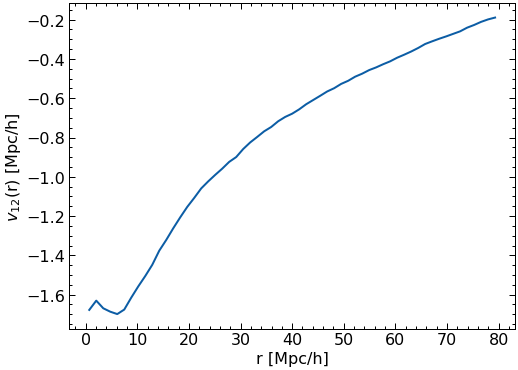

In [8]:
plt.plot(rbins_c, v_12)
plt.ylabel(r'$v_{12}$(r) [Mpc/h]')
plt.xlabel(r'r [Mpc/h]')

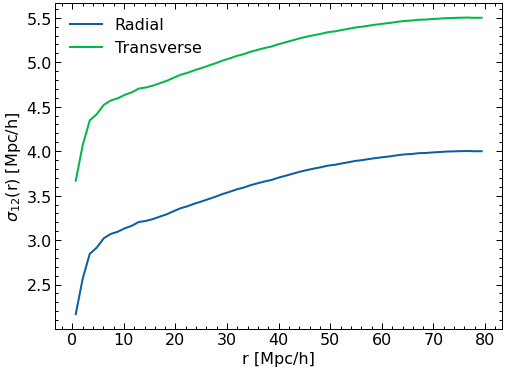

In [9]:
plt.plot(rbins_c, s_12_r, label='Radial')
plt.plot(rbins_c, s_12_t, label='Transverse')
plt.ylabel(r'$\sigma_{12}$(r) [Mpc/h]')
plt.xlabel(r'r [Mpc/h]')
plt.legend()

## Compute real and redshift space correlation functions

In [10]:
mu_bins = np.linspace(0,1,120)

In [11]:
%%time
real_tpcf = compute_real_tpcf(rbins, positions,
                              boxsize=halocat.Lbox)
s_mu_tpcf = compute_tpcf_s_mu(rbins, mu_bins, positions, 
                              velocities, los_direction=2,
                              redshift=0.,
                              cosmology=halocat.cosmology,
                              boxsize=halocat.Lbox)



CPU times: user 2min 30s, sys: 387 ms, total: 2min 31s
Wall time: 2min 33s


In [12]:
monopole = tpcf_multipole(s_mu_tpcf, mu_bins, order=0)
quadrupole = tpcf_multipole(s_mu_tpcf, mu_bins, order=2)
hexadecapole = tpcf_multipole(s_mu_tpcf, mu_bins, order=4)

Text(0.5, 0, 'r [Mpc/h]')

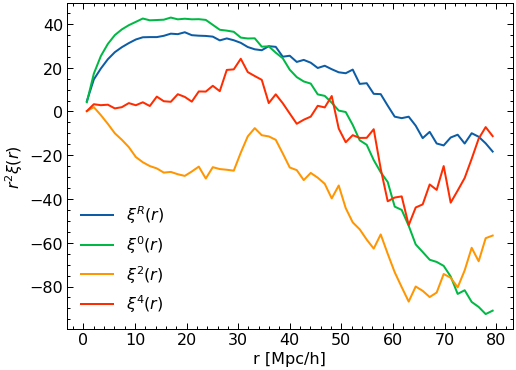

In [13]:
plt.plot(rbins_c, rbins_c**2*real_tpcf,
        label=r'$\xi^R(r)$')
plt.plot(rbins_c, rbins_c**2*monopole,
        label=r'$\xi^0(r)$')
plt.plot(rbins_c, rbins_c**2*quadrupole,
        label=r'$\xi^2(r)$')
plt.plot(rbins_c, rbins_c**2*hexadecapole,
        label=r'$\xi^4(r)$')
plt.legend()
plt.ylabel(r'$r^2\xi(r)$')
plt.xlabel('r [Mpc/h]')

## Use Gaussian Streaming Model to perform real to redshift space mapping

In [14]:
gaussian = moments2gaussian(
    m_10=UnivariateSpline(rbins_c, v_12,s=0,ext=3),
    c_20=UnivariateSpline(rbins_c,s_12_r,s=0,ext=3),
    c_02=UnivariateSpline(rbins_c,s_12_t,s=0,ext=3)
)

Text(0.5, 0, '$v_\\parallel [Mpc/h]$')

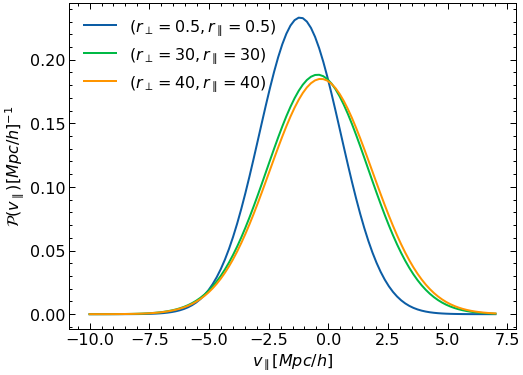

In [15]:
vlos = np.linspace(-10.,7.,100)
plt.plot(vlos, gaussian(vlos,r_perp=0.5,r_parallel=0.5)[0],
        label=r'$(r_\perp = 0.5, r_\parallel = 0.5)$')
plt.plot(vlos, gaussian(vlos,r_perp=30.,r_parallel=30.)[0],
        label=r'$(r_\perp = 30, r_\parallel = 30)$')
plt.plot(vlos, gaussian(vlos,r_perp=40.,r_parallel=40.)[0],
        label=r'$(r_\perp = 40, r_\parallel = 40)$')
plt.legend()
plt.ylabel(r'$\mathcal{P}(v_\parallel) [Mpc/h]^{-1}$')
plt.xlabel(r'$v_\parallel [Mpc/h]$')

In [16]:
gaussian_s_mu = real2redshift.simps_integrate(
    s=rbins, mu=mu_bins, 
    twopcf_function=UnivariateSpline(rbins_c, real_tpcf,s=0),
    los_pdf_function=gaussian,
)

In [17]:
gaussian_monopole = tpcf_multipole(gaussian_s_mu, mu_bins, 
                                   order=0)
gaussian_quadrupole = tpcf_multipole(gaussian_s_mu, mu_bins, 
                                     order=2)
gaussian_hexadecapole = tpcf_multipole(gaussian_s_mu, mu_bins, 
                                       order=4)

Text(0.5, 0, 'r [Mpc/h]')

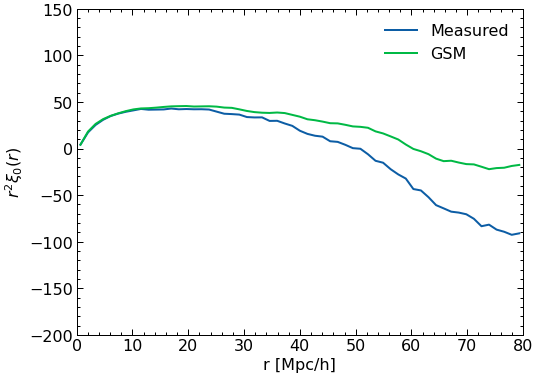

In [18]:
plt.plot(rbins_c, rbins_c**2*monopole,
        label='Measured')
plt.plot(rbins_c, rbins_c**2*gaussian_monopole,
        label='GSM')
plt.xlim(0,80) # if you want larger scales, extend the integration
# limit on simps integrate + extend UnivariateSpline limits 
# for moments and correlation function, remember it is an integral!
plt.ylim(-200,150)
plt.legend()
plt.ylabel(r'$r^2\xi_0(r)$')
plt.xlabel('r [Mpc/h]')

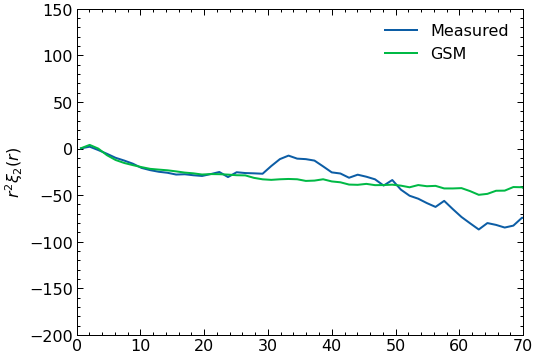

In [19]:
plt.plot(rbins_c, rbins_c**2*quadrupole,
        label='Measured')
plt.plot(rbins_c, rbins_c**2*gaussian_quadrupole,
        label='GSM')
plt.ylabel(r'$r^2\xi_2(r)$')

plt.xlim(0,70)
plt.ylim(-200,150)
plt.legend()